# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
import sys
print(sys.version)


3.9.6 (default, Aug 18 2021, 19:38:01) 
[GCC 7.5.0]


In [2]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 66, 
        'num_classes': 2,
        
        'function_generation_type': 'make_classification_vanilla_decision_tree_trained', # 'make_classification' 'random_decision_tree' 'random_decision_tree_trained' 'random_vanilla_decision_tree_trained' 'make_classification_vanilla_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [256],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.5, 0],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        
        'epochs': 200, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 2, # 1=standard representation; 2=sparse representation

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 1000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 500,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 500,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [3]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [4]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

import logging
from copy import deepcopy
#from prettytable import PrettyTable
#import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree



#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
#import tensorflow_addons as tfa
#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 



from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [5]:
tf.__version__

'2.5.1'

In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [8]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = (2 ** maximum_depth - 1) * number_of_variables + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes
config['function_family']['function_representation_length'] = ( 
       ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))
create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [9]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var66_class2_make_classification_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/256_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense512-1024_drop0.5-0e200b256_adam
lNetSize5000_numLNets10000_var66_class2_make_classification_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/256_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    path_X_data = directory + 'X_test_lambda.txt'
    path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    X_test_lambda = pd.read_csv(path_X_data, sep=",", header=None)
    X_test_lambda = X_test_lambda.sort_values(by=0)
    if no_noise == False:
        X_test_lambda = X_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    y_test_lambda = pd.read_csv(path_y_data, sep=",", header=None)
    y_test_lambda = y_test_lambda.sort_values(by=0)
    if no_noise == False:
        y_test_lambda = y_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              X_test_lambda_row, 
                                              y_test_lambda_row, 
                                              config) for network_parameters_row, X_test_lambda_row, y_test_lambda_row in zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values))          
    del parallel
    
    base_model = generate_base_model(config)  
    
    def initialize_network_wrapper(config, lambda_net, base_model):
        lambda_net.initialize_network(config, base_model)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    del parallel
    
    def initialize_target_function_wrapper(config, lambda_net):
        lambda_net.initialize_target_function(config)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    del parallel
        
    
    #lambda_nets = [None] * network_parameters.shape[0]
    #for i, (network_parameters_row, X_test_lambda_row, y_test_lambda_row) in tqdm(enumerate(zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values)), total=network_parameters.values.shape[0]):        
    #    lambda_net = LambdaNet(network_parameters_row, X_test_lambda_row, y_test_lambda_row, config)
    #    lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)    
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-3)]: Done 100 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-3)]: Done 260 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-3)]: Done 484 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-3)]: Done 1054 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-3)]: Done 1758 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-3)]: Done 2590 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-3)]: Done 3550 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-3)]: Done 4638 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-3)]: Done 5854 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 7198 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 8670 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:  1.8min finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jo

## Data Inspection

In [13]:
lambda_net_dataset_train.shape

(8955, 18448)

In [14]:
lambda_net_dataset_valid.shape

(995, 18448)

In [15]:
lambda_net_dataset_test.shape

(50, 18448)

In [16]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f0v10,f0v11,f0v12,f0v13,f0v14,f0v15,f0v16,f0v17,f0v18,f0v19,f0v20,f0v21,f0v22,f0v23,f0v24,f0v25,f0v26,f0v27,f0v28,f0v29,f0v30,f0v31,f0v32,f0v33,f0v34,f0v35,f0v36,f0v37,f0v38,f0v39,f0v40,f0v41,f0v42,f0v43,f0v44,f0v45,f0v46,f0v47,f0v48,f0v49,f0v50,f0v51,f0v52,f0v53,f0v54,f0v55,f0v56,f0v57,f0v58,f0v59,f0v60,f0v61,f0v62,f0v63,f0v64,f0v65,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f1v10,f1v11,f1v12,f1v13,f1v14,f1v15,f1v16,f1v17,f1v18,f1v19,f1v20,f1v21,f1v22,f1v23,f1v24,f1v25,f1v26,f1v27,f1v28,f1v29,f1v30,f1v31,...,wb_17309,wb_17310,wb_17311,wb_17312,wb_17313,wb_17314,wb_17315,wb_17316,wb_17317,wb_17318,wb_17319,wb_17320,wb_17321,wb_17322,wb_17323,wb_17324,wb_17325,wb_17326,wb_17327,wb_17328,wb_17329,wb_17330,wb_17331,wb_17332,wb_17333,wb_17334,wb_17335,wb_17336,wb_17337,wb_17338,wb_17339,wb_17340,wb_17341,wb_17342,wb_17343,wb_17344,wb_17345,wb_17346,wb_17347,wb_17348,wb_17349,wb_17350,wb_17351,wb_17352,wb_17353,wb_17354,wb_17355,wb_17356,wb_17357,wb_17358,wb_17359,wb_17360,wb_17361,wb_17362,wb_17363,wb_17364,wb_17365,wb_17366,wb_17367,wb_17368,wb_17369,wb_17370,wb_17371,wb_17372,wb_17373,wb_17374,wb_17375,wb_17376,wb_17377,wb_17378,wb_17379,wb_17380,wb_17381,wb_17382,wb_17383,wb_17384,wb_17385,wb_17386,wb_17387,wb_17388,wb_17389,wb_17390,wb_17391,wb_17392,wb_17393,wb_17394,wb_17395,wb_17396,wb_17397,wb_17398,wb_17399,wb_17400,wb_17401,wb_17402,wb_17403,wb_17404,wb_17405,wb_17406,wb_17407,wb_17408
6671,6671.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.253,-0.069,-0.146,-0.072,-0.074,-0.142,0.070,0.025,0.124,-0.108,-0.090,0.106,-0.115,-0.093,-0.147,0.025,-0.068,-0.166,-0.105,-0.137,-0.108,0.248,-0.143,-0.039,-0.121,-0.116,0.121,0.215,-0.151,0.255,-0.042,-0.141,-0.159,-0.162,-0.014,0.262,-0.091,-0.058,0.085,0.052,0.014,-0.042,-0.025,0.181,-0.151,-0.019,0.135,0.196,-0.193,0.111,0.118,0.149,-0.158,0.174,-0.032,0.111,0.144,0.009,0.094,0.229,-0.167,-0.128,-0.157,0.186,0.131,0.164,0.008,0.017,0.109,0.094,0.071,-0.061,-0.193,0.189,-0.156,0.209,-0.174,0.190,0.041,-0.143,-0.075,-0.012,0.205,0.204,0.050,0.130,-0.097,-0.046,-0.218,-0.116,-0.105,0.191,0.129,0.238,-0.098,0.120,-0.164,-0.124,0.217,0.011
3274,3274.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.130,-0.286,-0.143,-0.173,-0.315,-0.142,0.070,0.025,0.200,-0.108,-0.209,0.148,-0.111,-0.099,-0.046,0.025,-0.258,-0.171,-0.107,-0.137,-0.073,0.329,-0.134,-0.039,-0.119,-0.164,0.121,0.177,-0.152,0.300,-0.042,-0.006,-0.213,0.144,-0.014,0.069,-0.091,-0.058,0.162,0.244,0.014,-0.042,-0.171,0.160,-0.304,-0.159,0.135,0.236,-0.183,0.111,-0.195,0.221,-0.172,0.180,-0.032,0.120,0.350,0.143,0.229,0.332,-0.215,-0.170,-0.255,0.223,0.131,-0.092,0.011,0.017,0.083,0.170,0.076,-0.060,-0.051,0.148,-0.144,0.238,-0.169,0.062,0.041,-0.196,-0.081,-0.012,0.083,0.010,0.050,0.140,-0.105,-0.046,-0.231,-0.109,-0.107,0.222,0.277,0.239,-0.135,0.215,-0.161,-0.125,0.1

In [17]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f0v10,f0v11,f0v12,f0v13,f0v14,f0v15,f0v16,f0v17,f0v18,f0v19,f0v20,f0v21,f0v22,f0v23,f0v24,f0v25,f0v26,f0v27,f0v28,f0v29,f0v30,f0v31,f0v32,f0v33,f0v34,f0v35,f0v36,f0v37,f0v38,f0v39,f0v40,f0v41,f0v42,f0v43,f0v44,f0v45,f0v46,f0v47,f0v48,f0v49,f0v50,f0v51,f0v52,f0v53,f0v54,f0v55,f0v56,f0v57,f0v58,f0v59,f0v60,f0v61,f0v62,f0v63,f0v64,f0v65,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f1v10,f1v11,f1v12,f1v13,f1v14,f1v15,f1v16,f1v17,f1v18,f1v19,f1v20,f1v21,f1v22,f1v23,f1v24,f1v25,f1v26,f1v27,f1v28,f1v29,f1v30,f1v31,...,wb_17309,wb_17310,wb_17311,wb_17312,wb_17313,wb_17314,wb_17315,wb_17316,wb_17317,wb_17318,wb_17319,wb_17320,wb_17321,wb_17322,wb_17323,wb_17324,wb_17325,wb_17326,wb_17327,wb_17328,wb_17329,wb_17330,wb_17331,wb_17332,wb_17333,wb_17334,wb_17335,wb_17336,wb_17337,wb_17338,wb_17339,wb_17340,wb_17341,wb_17342,wb_17343,wb_17344,wb_17345,wb_17346,wb_17347,wb_17348,wb_17349,wb_17350,wb_17351,wb_17352,wb_17353,wb_17354,wb_17355,wb_17356,wb_17357,wb_17358,wb_17359,wb_17360,wb_17361,wb_17362,wb_17363,wb_17364,wb_17365,wb_17366,wb_17367,wb_17368,wb_17369,wb_17370,wb_17371,wb_17372,wb_17373,wb_17374,wb_17375,wb_17376,wb_17377,wb_17378,wb_17379,wb_17380,wb_17381,wb_17382,wb_17383,wb_17384,wb_17385,wb_17386,wb_17387,wb_17388,wb_17389,wb_17390,wb_17391,wb_17392,wb_17393,wb_17394,wb_17395,wb_17396,wb_17397,wb_17398,wb_17399,wb_17400,wb_17401,wb_17402,wb_17403,wb_17404,wb_17405,wb_17406,wb_17407,wb_17408
3466,3466.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.142,0.164,-0.139,-0.071,-0.074,-0.142,0.070,0.025,0.100,-0.103,-0.181,0.264,-0.123,-0.245,-0.220,0.027,-0.219,-0.232,-0.105,-0.137,-0.114,0.268,-0.190,-0.039,-0.120,-0.091,0.265,0.268,-0.150,0.144,-0.042,-0.160,-0.034,0.142,-0.009,0.249,-0.091,-0.058,0.090,0.054,0.014,-0.040,-0.024,0.226,-0.200,-0.013,0.127,0.105,-0.189,0.211,0.003,0.180,-0.057,0.213,-0.032,0.110,0.144,0.195,0.167,0.275,-0.187,-0.063,-0.242,0.252,0.131,-0.100,0.211,0.017,0.131,0.030,0.072,-0.057,-0.442,0.093,-0.289,0.130,-0.108,0.172,0.041,-0.169,-0.077,-0.203,0.115,0.011,0.050,0.306,-0.093,-0.046,-0.240,-0.148,-0.334,0.227,0.256,0.219,-0.139,0.129,-0.098,-0.262,0.204,0.012
689,689.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.130,-0.002,-0.126,-0.076,-0.074,-0.142,0.070,0.027,0.190,-0.108,-0.182,0.260,0.003,-0.086,-0.060,0.173,-0.145,-0.163,-0.103,-0.137,-0.178,0.142,-0.224,-0.039,-0.121,-0.136,0.096,0.060,-0.252,0.291,-0.042,-0.196,-0.144,0.145,-0.014,0.069,-0.091,-0.058,0.257,0.217,0.014,-0.040,-0.031,0.155,-0.140,-0.013,0.135,0.150,-0.238,0.193,0.176,0.055,-0.126,0.131,-0.032,0.111,0.208,0.006,0.229,0.146,-0.108,-0.121,-0.009,0.176,0.131,-0.112,0.015,0.017,0.099,0.014,0.075,-0.061,-0.203,0.129,-0.279,0.157,-0.178,0.128,0.041,-0.139,-0.083,-0.012,0.080,0.006,0.050,0.124,-0.190,-0.046,-0.135,-0.180,-0.230,0.173,0.170,0.217,-0.163,0.116,-0.173,-0.130,0.289,0.

In [18]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f0v10,f0v11,f0v12,f0v13,f0v14,f0v15,f0v16,f0v17,f0v18,f0v19,f0v20,f0v21,f0v22,f0v23,f0v24,f0v25,f0v26,f0v27,f0v28,f0v29,f0v30,f0v31,f0v32,f0v33,f0v34,f0v35,f0v36,f0v37,f0v38,f0v39,f0v40,f0v41,f0v42,f0v43,f0v44,f0v45,f0v46,f0v47,f0v48,f0v49,f0v50,f0v51,f0v52,f0v53,f0v54,f0v55,f0v56,f0v57,f0v58,f0v59,f0v60,f0v61,f0v62,f0v63,f0v64,f0v65,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f1v10,f1v11,f1v12,f1v13,f1v14,f1v15,f1v16,f1v17,f1v18,f1v19,f1v20,f1v21,f1v22,f1v23,f1v24,f1v25,f1v26,f1v27,f1v28,f1v29,f1v30,f1v31,...,wb_17309,wb_17310,wb_17311,wb_17312,wb_17313,wb_17314,wb_17315,wb_17316,wb_17317,wb_17318,wb_17319,wb_17320,wb_17321,wb_17322,wb_17323,wb_17324,wb_17325,wb_17326,wb_17327,wb_17328,wb_17329,wb_17330,wb_17331,wb_17332,wb_17333,wb_17334,wb_17335,wb_17336,wb_17337,wb_17338,wb_17339,wb_17340,wb_17341,wb_17342,wb_17343,wb_17344,wb_17345,wb_17346,wb_17347,wb_17348,wb_17349,wb_17350,wb_17351,wb_17352,wb_17353,wb_17354,wb_17355,wb_17356,wb_17357,wb_17358,wb_17359,wb_17360,wb_17361,wb_17362,wb_17363,wb_17364,wb_17365,wb_17366,wb_17367,wb_17368,wb_17369,wb_17370,wb_17371,wb_17372,wb_17373,wb_17374,wb_17375,wb_17376,wb_17377,wb_17378,wb_17379,wb_17380,wb_17381,wb_17382,wb_17383,wb_17384,wb_17385,wb_17386,wb_17387,wb_17388,wb_17389,wb_17390,wb_17391,wb_17392,wb_17393,wb_17394,wb_17395,wb_17396,wb_17397,wb_17398,wb_17399,wb_17400,wb_17401,wb_17402,wb_17403,wb_17404,wb_17405,wb_17406,wb_17407,wb_17408
7217,7217.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.172,0.258,-0.139,-0.077,-0.068,-0.142,0.070,0.025,0.166,-0.108,-0.212,0.225,-0.055,-0.072,-0.036,0.030,-0.111,0.010,-0.315,-0.258,-0.162,0.143,-0.285,-0.039,-0.143,-0.101,0.084,0.119,-0.152,0.139,-0.042,0.006,-0.127,0.197,-0.014,0.245,-0.091,-0.058,0.392,0.035,0.014,-0.042,-0.191,0.104,-0.005,-0.066,0.135,0.136,-0.254,0.113,-0.259,0.311,-0.181,0.302,-0.032,0.353,0.272,0.264,0.282,0.140,-0.130,-0.121,-0.110,0.195,0.131,-0.163,0.008,0.017,0.146,0.036,0.076,-0.060,-0.053,0.194,-0.355,0.133,-0.011,0.268,0.041,-0.205,-0.088,-0.012,0.238,0.010,0.050,0.122,-0.308,-0.046,-0.277,-0.131,-0.104,0.253,-0.197,0.228,-0.185,0.162,-0.165,-0.129,0.313,-0.013
8291,8291.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.298,-0.131,-0.126,-0.225,-0.074,-0.142,0.070,0.025,0.163,-0.107,-0.174,0.234,-0.049,-0.087,-0.051,0.203,-0.026,-0.102,-0.096,-0.137,-0.064,0.143,-0.244,-0.039,-0.121,-0.081,0.085,0.152,-0.152,0.288,-0.042,0.004,-0.103,-0.066,-0.014,0.071,-0.091,-0.058,0.092,0.043,0.014,-0.042,-0.031,0.130,-0.159,-0.014,0.135,0.099,-0.218,0.111,-0.175,0.177,-0.068,0.233,-0.032,0.137,0.141,0.008,0.093,0.194,-0.116,-0.091,-0.137,0.209,0.131,0.150,0.005,0.017,0.014,0.165,0.071,-0.054,-0.243,0.157,-0.285,0.167,-0.160,0.060,0.041,-0.154,-0.216,-0.033,0.079,0.011,0.050,0.131,-0.103,-0.046,-0.241,-0.106,-0.114,0.149,0.178,0.260,-0.109,0.073,-0.136,-0.125,0.12

## Interpretation Network Training

In [19]:
#%load_ext autoreload

In [20]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 history,

 model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['plot_losses']
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/200
35/35 [==============================] - 22s 398ms/step - loss: 0.6973 - binary_accuracy_inet_decision_function_fv_metric: 0.5026 - val_loss: 0.6931 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5048
Epoch 2/200
35/35 [==============================] - 10s 297ms/step - loss: 0.6928 - binary_accuracy_inet_decision_function_fv_metric: 0.5084 - val_loss: 0.6928 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5067
Epoch 3/200
35/35 [==============================] - 10s 291ms/step - loss: 0.6926 - binary_accuracy_inet_decision_function_fv_metric: 0.5078 - val_loss: 0.6925 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5099
Epoch 4/200
35/35 [==============================] - 10s 288ms/step - loss: 0.6924 - binary_accuracy_inet_decision_function_fv_metric: 0.5081 - val_loss: 0.6922 - val_binary_accuracy_inet_decision_functio

<Figure size 432x288 with 0 Axes>

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 17409)]      0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          8913920     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.5 (Dropout)          (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [23]:
y_test_inet_dt_list = []
y_test_distilled_sklearn_dt_list = []

binary_crossentropy_distilled_sklearn_dt_list =[]
accuracy_distilled_sklearn_dt_list = []
f1_score_distilled_sklearn_dt_list = []

binary_crossentropy_inet_dt_list =[]
accuracy_inet_dt_list = []
f1_score_inet_dt_list = []

#inet_metric_function_list = []

number = lambda_net_dataset_test.y_test_lambda_array.shape[0]#10

for lambda_net_parameters, lambda_net, X_test_lambda, y_test_lambda in tqdm(zip(lambda_net_dataset_test.network_parameters_array[:number], lambda_net_dataset_test.network_list[:number], lambda_net_dataset_test.X_test_lambda_array[:number], lambda_net_dataset_test.y_test_lambda_array[:number]), total=lambda_net_dataset_test.y_test_lambda_array[:number].shape[0]):
    dt_inet = model.predict(np.array([lambda_net_parameters]))[0]
    if nas:
        dt_inet = dt_inet[:function_representation_length]

    
    X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
    y_data_random_lambda_pred = lambda_net.predict(X_data_random)
    y_data_random_lambda_pred = np.round(y_data_random_lambda_pred).astype(np.int64)
    
    dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
    dt_sklearn_distilled.fit(X_data_random, y_data_random_lambda_pred)
    
    
    if dt_type == 'SDT':
        y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    elif dt_type == 'vanilla':
        y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_lambda)
    
    y_test_lambda_pred = lambda_net.predict(X_test_lambda)
    y_test_lambda_pred = np.round(y_test_lambda_pred)
    
    
    #random_model = generate_base_model(config)        
    #random_network_parameters = random_model.get_weights()
    #network_parameters_structure = [network_parameter.shape for network_parameter in random_network_parameters]         
    
    #function_true_placeholder = np.array([0 for i in range(basic_function_representation_length)])
    #function_true_with_network_parameters = np.concatenate([function_true_placeholder, lambda_net_parameters])
    #inet_metric_function = inet_decision_function_fv_metric_wrapper(X_test_lambda, 
    #                                                                 random_model, 
    #                                                                 network_parameters_structure, 
    #                                                                 config, 
    #                                                                 'binary_accuracy')(np.array([function_true_with_network_parameters]), 
    #                                                                                     np.array([dt_inet]))    
    #inet_metric_function_list.append(inet_metric_function)
        
    
    
    binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_lambda_pred, y_test_distilled_sklearn_dt)
    accuracy_distilled_sklearn_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt = f1_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    
    binary_crossentropy_inet_dt = log_loss(y_test_lambda_pred, y_test_inet_dt)
    accuracy_inet_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    f1_score_inet_dt = f1_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    
    
    y_test_inet_dt_list.append(y_test_inet_dt)
    y_test_distilled_sklearn_dt_list.append(y_test_distilled_sklearn_dt)    

    binary_crossentropy_distilled_sklearn_dt_list.append(np.nan_to_num(binary_crossentropy_distilled_sklearn_dt))
    accuracy_distilled_sklearn_dt_list.append(np.nan_to_num(accuracy_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt_list.append(np.nan_to_num(f1_score_distilled_sklearn_dt))

    binary_crossentropy_inet_dt_list.append(np.nan_to_num(binary_crossentropy_inet_dt))
    accuracy_inet_dt_list.append(np.nan_to_num(accuracy_inet_dt))
    f1_score_inet_dt_list.append(np.nan_to_num(f1_score_inet_dt))
    
y_test_inet_dt_list = np.array(y_test_inet_dt_list)
y_test_distilled_sklearn_dt_list = np.array(y_test_distilled_sklearn_dt_list)

binary_crossentropy_distilled_sklearn_dt_list = np.array(binary_crossentropy_distilled_sklearn_dt_list)
accuracy_distilled_sklearn_dt_list = np.array(accuracy_distilled_sklearn_dt_list)
f1_score_distilled_sklearn_dt_list = np.array(f1_score_distilled_sklearn_dt_list)

binary_crossentropy_inet_dt_list = np.array(binary_crossentropy_inet_dt_list)
accuracy_inet_dt_list = np.array(accuracy_inet_dt_list)
f1_score_inet_dt_list = np.array(f1_score_inet_dt_list)    

    
print('Binary Crossentropy:\t\t', np.round(np.mean(binary_crossentropy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(binary_crossentropy_inet_dt_list), 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(np.mean(accuracy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(accuracy_inet_dt_list), 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(np.mean(f1_score_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(f1_score_inet_dt_list), 3), '(I-Net DT)')
      

  0%|          | 0/50 [00:00<?, ?it/s]

Binary Crossentropy:		 9.985 (Sklearn DT) 	 0.688 (I-Net DT)
Accuracy:		 0.711 (Sklearn DT) 	 0.552 (I-Net DT)
F1 Score:		 0.667 (Sklearn DT) 	 0.204 (I-Net DT)


# REAL DATA EVALUATION

## ADULT DATASET

In [69]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



dataframe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)
dataframe = dataframe.drop([
                             #"Age", #0
                             #"Workclass",  #1
                             #"fnlwgt",  #2
                             #"Education",  #3
                             #"Education-Num",  #4
                             #"Marital Status", #5
                             #"Occupation",  #6
                             #"Relationship",  #7
                             #"Race",  #8
                             #"Sex",  #9 
                             #"Capital Gain",  #10
                             #"Capital Loss", #11
                             #"Hours per week",  #12
                             "Country", #13
                            ] , axis=1)

categorical_features = [
                        1, #"Workclass"
                        3, #"Education"
                        5, #"Marital Status"
                        6, #"Occupation"
                        7, #"Relationship"
                        8, #"Race"
                        9, #"Sex"
                        #13, #"Country
                       ] 


data = dataframe.values



In [70]:
dataframe

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,capital_gain
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K


In [71]:
dataframe.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000,32561.000,32561.000,32561.000,32561.000,32561.000
mean,38.582,189778.367,10.081,1077.649,87.304,40.437
std,13.640,105549.978,2.573,7385.292,402.960,12.347
min,17.000,12285.000,1.000,0.000,0.000,1.000
25%,28.000,117827.000,9.000,0.000,0.000,40.000
50%,37.000,178356.000,10.000,0.000,0.000,40.000
75%,48.000,237051.000,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


In [72]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours per week  32561 non-null  int64 
 13  capital_gain    32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [73]:
dataframe['capital_gain'].value_counts()


 <=50K    24720
 >50K      7841
Name: capital_gain, dtype: int64

In [74]:
data.shape

(32561, 14)

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

In [76]:
labels = data[:,data.shape[1]-1]
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data[:,:-1]

In [77]:
print(data.shape)

(32561, 13)


In [78]:
data[:5]

array([[39, ' State-gov', 77516, ' Bachelors', 13, ' Never-married',
        ' Adm-clerical', ' Not-in-family', ' White', ' Male', 2174, 0,
        40],
       [50, ' Self-emp-not-inc', 83311, ' Bachelors', 13,
        ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White',
        ' Male', 0, 0, 13],
       [38, ' Private', 215646, ' HS-grad', 9, ' Divorced',
        ' Handlers-cleaners', ' Not-in-family', ' White', ' Male', 0, 0,
        40],
       [53, ' Private', 234721, ' 11th', 7, ' Married-civ-spouse',
        ' Handlers-cleaners', ' Husband', ' Black', ' Male', 0, 0, 40],
       [28, ' Private', 338409, ' Bachelors', 13, ' Married-civ-spouse',
        ' Prof-specialty', ' Wife', ' Black', ' Female', 0, 0, 40]],
      dtype=object)

In [79]:
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough')
transformer.fit(data)

data = transformer.transform(data)
data = data.toarray()
data = data.astype(np.float64)

In [80]:
data[:5]

array([[   0.,    0.,    0., ..., 2174.,    0.,   40.],
       [   0.,    0.,    0., ...,    0.,    0.,   13.],
       [   0.,    0.,    0., ...,    0.,    0.,   40.],
       [   0.,    0.,    0., ...,    0.,    0.,   40.],
       [   0.,    0.,    0., ...,    0.,    0.,   40.]])

In [81]:
transpose = data.transpose()
normalizer_list = []
transpose_normalized = []
for column in transpose:
    scaler = MinMaxScaler()
    scaler.fit(column.reshape(-1, 1))
    column_new = scaler.transform(column.reshape(-1, 1)).ravel()
    transpose_normalized.append(column_new)
    normalizer_list.append(scaler)
data = np.array(transpose_normalized).transpose()

#data = data / data.max(axis=0)

In [82]:
print(data.shape)

(32561, 66)


In [83]:
data[:5]

array([[0.        , 0.        , 0.        , ..., 0.02174022, 0.        ,
        0.39795918],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12244898],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.39795918],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.39795918],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.39795918]])

In [84]:
train_with_valid, test, labels_train_with_valid, labels_test = train_test_split(data, labels, train_size=0.8)
train, valid, labels_train, labels_valid = train_test_split(train_with_valid, labels_train_with_valid, train_size=0.8)


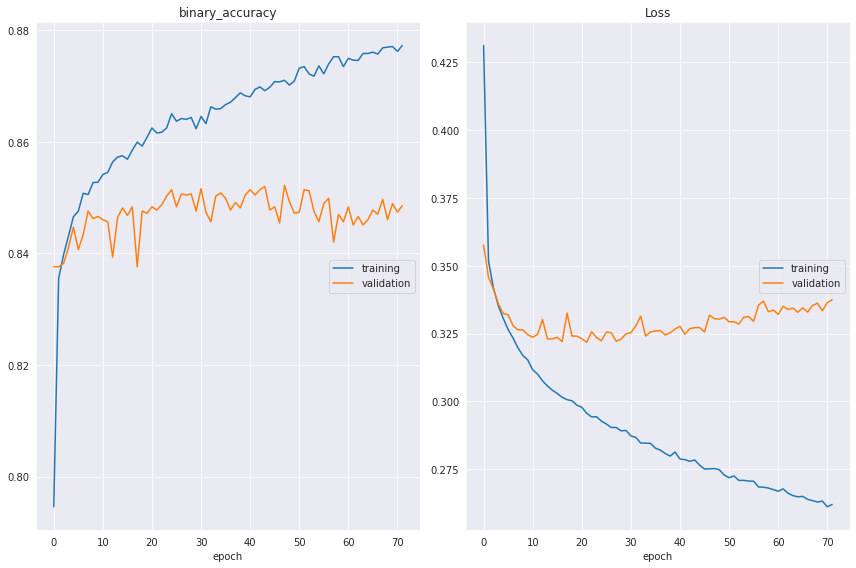

binary_accuracy
	training         	 (min:    0.795, max:    0.877, cur:    0.877)
	validation       	 (min:    0.838, max:    0.852, cur:    0.849)
Loss
	training         	 (min:    0.261, max:    0.431, cur:    0.262)
	validation       	 (min:    0.322, max:    0.358, cur:    0.338)


In [85]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(train,
                                  labels_train, 
                                  epochs=1000, 
                                  batch_size=256, 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(valid, labels_valid),
                                  verbose=0)



In [86]:
test_network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               17152     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


In [87]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(test, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(test, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(test)

y_test_test_network_pred = test_network.predict(test)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt)
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt)
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


Binary Crossentropy:		 27.439 (Sklearn DT) 	 0.548 (I-Net DT)
Accuracy:		 0.206 (Sklearn DT) 	 0.795 (I-Net DT)
F1 Score:		 0.341 (Sklearn DT) 	 0.0 (I-Net DT)


In [95]:
y_test_test_network_pred[:200].ravel()

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [98]:
np.round(y_test_inet_dt[:200]).ravel()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [97]:
y_test_distilled_sklearn_dt[:200].ravel()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [88]:
splits, leaf_classes = get_shaped_parameters_for_decision_tree(test_network_dt_inet, config)
print(splits, leaf_classes)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(15, 66), dtype=float32) tf.Tensor(
[0.6662351  0.6617867  0.67655206 0.6860422  0.66652393 0.676929
 0.678207   0.6945045  0.6676824  0.66443664 0.6633085  0.6719289
 0.7125245  0.69694066 0.6835489  0.68521565], shape=(16,), dtype=float32)


In [89]:
#%load_ext autoreload

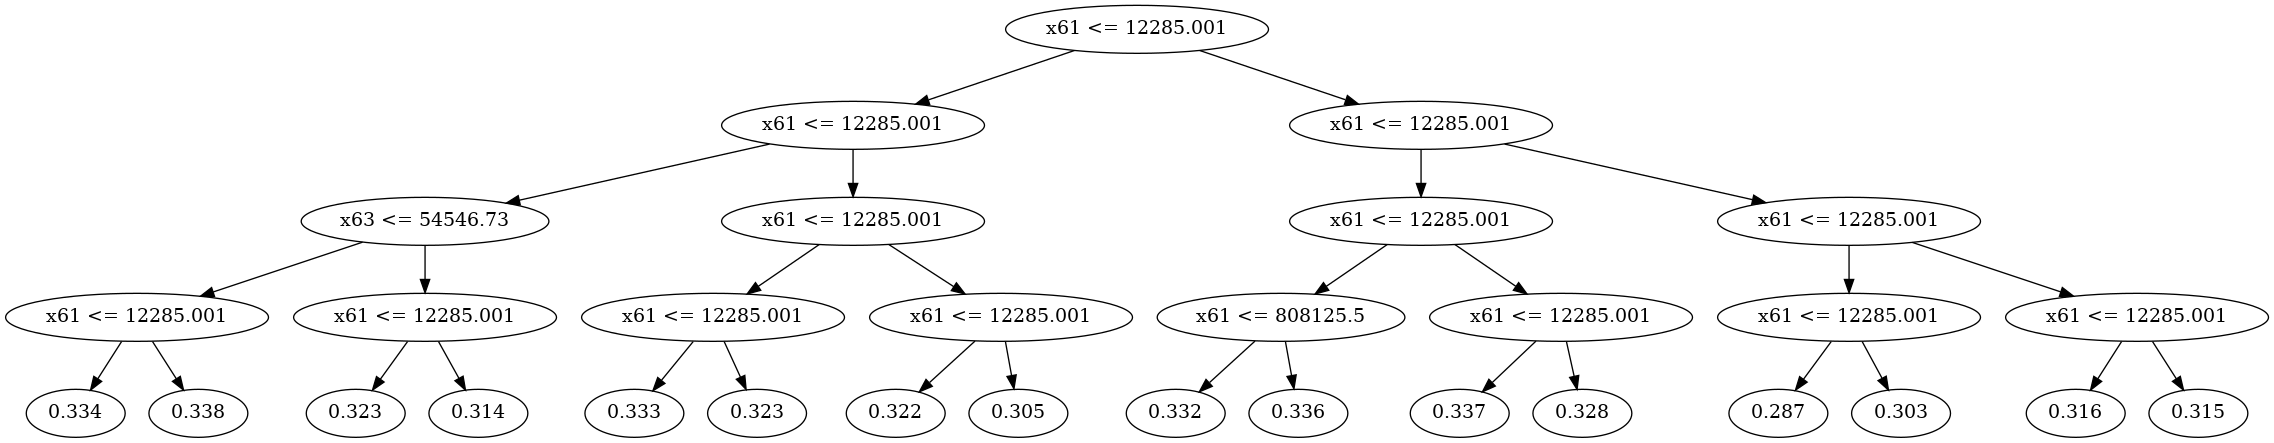

In [90]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

In [91]:
tree = treelib_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
#tree = treelib_decision_tree_from_parameters(test_network_dt_inet, config=config)

tree.show()

x61 <= 12285.001
├── x61 <= 12285.001
│   ├── x61 <= 12285.001
│   │   ├── x61 <= 12285.001
│   │   │   ├── 0.323
│   │   │   └── 0.333
│   │   └── x61 <= 12285.001
│   │       ├── 0.305
│   │       └── 0.322
│   └── x63 <= 54546.73
│       ├── x61 <= 12285.001
│       │   ├── 0.334
│       │   └── 0.338
│       └── x61 <= 12285.001
│           ├── 0.314
│           └── 0.323
└── x61 <= 12285.001
    ├── x61 <= 12285.001
    │   ├── x61 <= 12285.001
    │   │   ├── 0.328
    │   │   └── 0.337
    │   └── x61 <= 808125.5
    │       ├── 0.332
    │       └── 0.336
    └── x61 <= 12285.001
        ├── x61 <= 12285.001
        │   ├── 0.287
        │   └── 0.303
        └── x61 <= 12285.001
            ├── 0.315
            └── 0.316



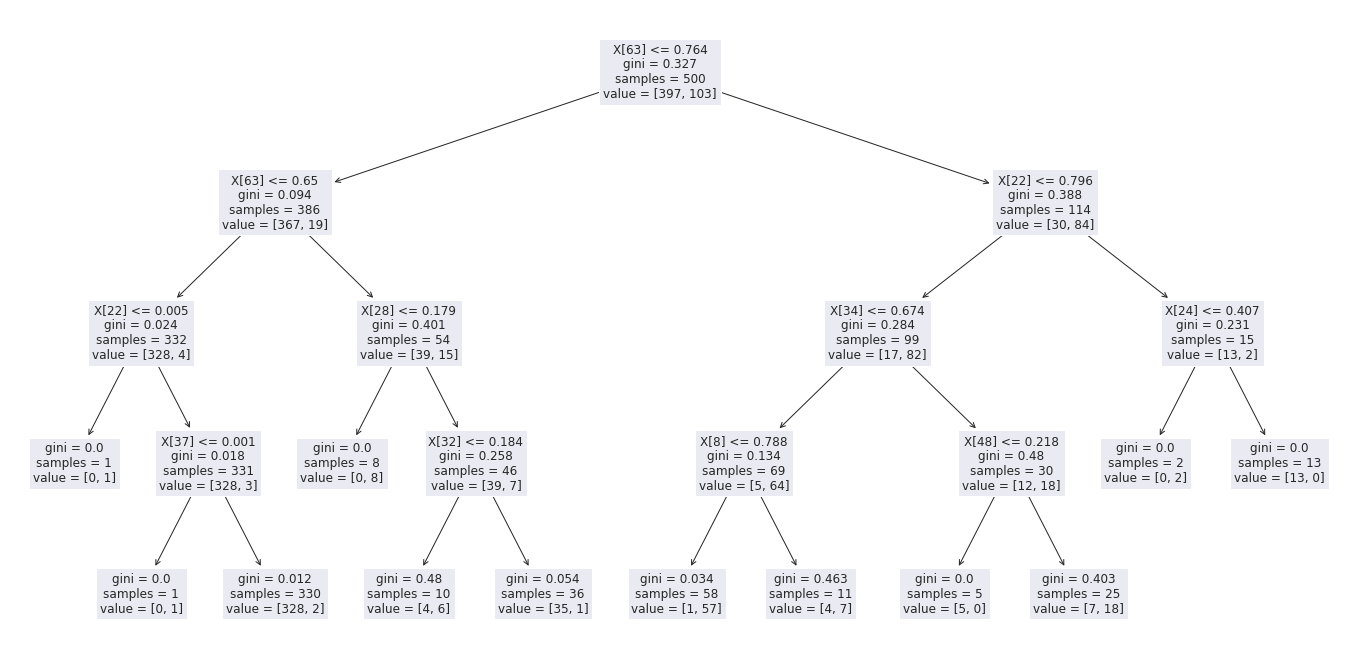

In [93]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

## NEXT DATASET